In [424]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import sys, os
import numpy as np
import lumapi


In [425]:
emeApi = lumapi.MODE()

## Funções

In [426]:
def achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(funcao, x, xmin, xmax):
    # Esta funcao analisa o maior valor de "funcao" dentro do intervalo xmin<=x<=xmax retornando x e y onde ocorreu maximo de funcao.
    # funcao - Array na qual deseja-se encontrar o maximo valor. variavel dependente
    # x - Array que sera varrido. variavel independente
    # xmin - float valor inicial
    # xmax - float valor final

    mask = (x >= xmin) & (x <= xmax) #mask eh um vetor modificado de x, sendo limitado no intervalo fornecido
    
    if not np.any(mask): #se o intervalo fornecido nao condizer com o vetor x, retorna None
        return None, None
    
    funcao_intervalo = funcao[mask] #funcao_intervalo eh um vetor modificado de "funcao". basicamente eh "funcao" truncado na "mask"
    peak = max(funcao_intervalo) #procura o maximo dentro de funcao_intervalo
    index = np.where(funcao==peak)[0][0] #indice onde o maximo ocorreu na primeira vez.
    x_maximo = x[index] #x_maximo eh o valor de x para o maximo achado

    y_maximo = funcao[index] #y_maximo eh o valor de y para o maximo achado
    
    return round(x_maximo,6),round(y_maximo,6) #eh retornado os valores com aproximacao de 6 casas decimais

def analise_comprimento_de_onda_para_sensor(parametro_variavel, Transmissao, comprimento_de_onda, x_min,x_max):
    # Essa funcao obtem as transmissoes em funcao do comprimento de onda para cada parametro variavel (temperatura ou strain) e retorna dois Arrays: 
    # um para comprimento de onda de pico e outro para transmissao de pico onde houve pico de transmissao para cada parametrovariavel. 

    # parametro_variavel - Array com o parametro que esta sendo variado. Ex: pressao, temperatura, tensao, deformacao. 
    # transmissao - Array de array com a transmissao para cada parametro variado. len(transmissao) == len(parametro_variavel)
    # comprimento_de_onda - Array com os comprimentos de onda. len(transmissao[i])==len(comprimento_de_onda)
    # x_min - float valor minimo do intervalo
    # x_max - float valor maximo do intervalo

    frequencia_onde_ocorre_maxima_transmissao = np.zeros(len(parametro_variavel))
    Amplitude_onde_ocorre_maxima_transmissao = np.zeros(len(parametro_variavel))

    for i in range(len(parametro_variavel)):
        x_pico, y_pico = achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(Transmissao[i],comprimento_de_onda, x_min,x_max)
        frequencia_onde_ocorre_maxima_transmissao[i] = (x_pico)
        Amplitude_onde_ocorre_maxima_transmissao[i] = (y_pico)
    
    return frequencia_onde_ocorre_maxima_transmissao, Amplitude_onde_ocorre_maxima_transmissao

def funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_1,defasagem,diretorio_dos_parametros_S):
        # funcao cria ambiente de simulacao no INTERCONNECT composto por dois laser, um combiner, um dispositivo arbitrario (a depender do parametro S),
        #  um splitter, dois filtros, dois fotodectores e dois medidores de potencia. Posteriormente simula e retorna os valores de potencia lidos nos medidores de potencia.

        # inter - referente a funcao da API lumapi. inter = lumapi.INTERCONNECT().
        # x_1 - float - comprimento de onda do laser 1.
        # defasagem - float - comprimento de onda defasado de x_1. a soma defasagem+x_1 eh o comprimento de onda do laser 2.
        # diretorio_dos_parametros_S - string - diretorio com o nome do arquivo com parametro S .dat
         
        inter.switchtolayout()
        inter.deleteall()

        inter.addelement("CW Laser")
        inter.set("name", "fonte1")
        inter.set("frequency", 3e8/(x_1))

        inter.addelement("CW Laser")
        inter.set("name", "fonte2")
        inter.set("frequency", 3e8/((x_1 + defasagem)))

        inter.addelement("Optical Combiner")
        inter.set("name", "optC1")

        inter.addelement("Optical Combiner")
        inter.set("configuration", "splitter")
        inter.set("name", "optS1")
        inter.rotateelement("optS1")
        inter.rotateelement("optS1")

        inter.addelement("Optical N Port S-Parameter")
        inter.set("name","spars1")
        inter.set("load from file", True)
        inter.set("s parameters filename", diretorio_dos_parametros_S)

        inter.addelement("Rectangular Optical Filter")
        inter.set("name","filter1")
        inter.set("frequency", 3e8/(x_1))

        inter.addelement("Rectangular Optical Filter")
        inter.set("name","filter2")
        inter.set("frequency", 3e8/((x_1 + defasagem)))

        inter.addelement("PIN Photodetector")
        inter.set("name", "photodec1")
        inter.addelement("PIN Photodetector")
        inter.set("name", "photodec2")

        inter.addelement("Power Meter")
        inter.set("name", "PM1")
        inter.addelement("Power Meter")
        inter.set("name","PM2")

        inter.setposition("fonte1", 0,0)
        inter.setposition("fonte1", 0,200)

        inter.setposition("optC1", 200,100)
        inter.setposition("spars1", 400,100)
        inter.setposition("optS1", 600,100)

        inter.setposition("filter1", 800,0)
        inter.setposition("filter2", 800,200)

        inter.setposition("photodec1", 1000,0)
        inter.setposition("photodec2", 1000,200)

        inter.setposition("PM1", 1200,0)
        inter.setposition("PM2", 1200,200)

        inter.connect("fonte2", "output", "optC1", "input 1")
        inter.connect("fonte1", "output", "optC1", "input 2")

        inter.connect("optC1", "output", "spars1", "port 1")
        inter.connect("spars1", "port 2", "optS1", "input")

        inter.connect("filter1", "input", "optS1", "output 2")
        inter.connect("filter2", "input", "optS1", "output 1")

        inter.connect("photodec1", "input", "filter1", "output")
        inter.connect("photodec2", "input", "filter2", "output")

        inter.connect("PM1", "input", "photodec1", "output")
        inter.connect("PM2", "input", "photodec2", "output")

        inter.run()

        return (inter.getresult("PM1","total power")),(inter.getresult("PM2","total power"))


In [427]:
emeApi.importmaterialdb('silicon_thermal.mdf')

## Parâmetros Geometria

In [428]:
um = 1e-6
nm = 1e-9

thickness = 0.22*um
thick_BOX = 2*um

W_bragg = 1530*nm

width = 0.5*um # Waveguide width
Delta_W = 20*nm # Corrugation width
W_great = width+ Delta_W
W_small = width - Delta_W

L_pd = 324*nm # Grating period

# W_ox = 3*um 
# L_ex = 2*um # simulation size margins

material_Si ='silicon_thermal' #"Si (Silicon) - Palik"
material_BOX = "SiO2 (Glass) - Palik"

w_box = 2*width
t_box = 2*um
nb = 10000
wvg = np.linspace(1500e-9, 1600e-9, nb)


## Parâmetros Temperatura

In [429]:
Temperatura = np.linspace(25,75,0)+273



## Parâmetros Strain

In [430]:
S = np.linspace(0,0.008,11)

print(S*1e3," milistrain")

[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]  milistrain


## Geometry

In [431]:
emeApi.deleteall()

#bragg grating
emeApi.addrect()
emeApi.set('x', -L_pd/4)
emeApi.set('x span', L_pd/2)
emeApi.set('y',0)
emeApi.set('y span', W_great)
emeApi.set('z',0)
emeApi.set('z span', thickness)
emeApi.set('material', material_Si)
emeApi.set('name', 'grt_big')

emeApi.addrect()
emeApi.set('x', L_pd/4)
emeApi.set('x span', L_pd/2)
emeApi.set('y',0)
emeApi.set('y span', W_small)
emeApi.set('z',0)
emeApi.set('z span', thickness)
emeApi.set('material', material_Si)
emeApi.set('name', 'grt_small')


In [432]:
emeApi.selectpartial('grt')
emeApi.addtogroup('grt_cell')
emeApi.select('grt_cell')
emeApi.selectpartial('grt_cell')
emeApi.addtogroup('bragg')

## Solver FDE

In [433]:
emeApi.switchtolayout()

emeApi.select('FDE')
emeApi.delete()

emeApi.addfde()
emeApi.set("simulation temperature", 298)
emeApi.set("background material", material_BOX)
emeApi.set("solver type", "2D X normal")
emeApi.set("y min bc", "Anti-Symmetric")
emeApi.set("y max bc", "Metal")
emeApi.set("z min bc", "Symmetric")
emeApi.set("y max bc", "Metal")
emeApi.set('x',-L_pd/4)
emeApi.set('z', 0)
emeApi.set('y', 0)
emeApi.set('y span', 3*width)
emeApi.set('z span', 3*thickness)

In [434]:
emeApi.select('mesh')
emeApi.delete()

emeApi.addmesh()
emeApi.set("x", 0)
emeApi.set('z', 0)
emeApi.set('y', 0)
emeApi.set('x span', L_pd)
emeApi.set('y span', 3*W_great)
emeApi.set('z span', 3*thickness)
emeApi.set("set mesh multiplier", 1)
emeApi.set('x mesh multiplier', 5)
emeApi.set('y mesh multiplier', 5)
emeApi.set('z mesh multiplier', 5)

In [435]:
emeApi.save("Bragg")

In [436]:
emeApi.switchtolayout()
emeApi.select("FDE")
emeApi.set("x", L_pd/4)
emeApi.findmodes()

group_index_high = np.abs(emeApi.getresult("FDE::data::mode1", "ng")[0][0])
neff_high = np.abs(emeApi.getresult("FDE::data::mode1", "neff")[0][0])
print("high index - ng = ", group_index_high," neff = ", neff_high)


emeApi.switchtolayout()
emeApi.select("FDE")
emeApi.set("x", -L_pd/4)
emeApi.findmodes()

group_index_low = np.abs(emeApi.getresult("FDE::data::mode1", "ng")[0][0])
neff_low = np.abs(emeApi.getresult("FDE::data::mode1", "neff")[0][0])
print("low index - ng = ", group_index_low," neff = ", neff_low)

high index - ng =  4.455372480362521  neff =  2.39059927839474
low index - ng =  4.357813467947366  neff =  2.4567195569011635


## Bragg periodicity ($\Lambda$)

$$
\Lambda = \frac{\lambda_{Bragg}}{2n_{eff}}
$$

Where,

$$
n_{eff} = \frac{{n_{eff}}_1+{n_{eff}}_2}{2}
$$

In [437]:
Lambda = W_bragg/((neff_low+neff_high))
print("Lambda = ", Lambda*1e9, " nm")

Lambda =  315.6384079502379  nm


## Solver EME Temperature

In [438]:
emeApi.switchtolayout()
emeApi.select('EME')
emeApi.delete()

emeApi.addeme()
emeApi.set("simulation temperature", 298)
emeApi.set("solver type", "3D: X prop")
emeApi.set("energy conservation", "conserve energy")
emeApi.set("background material", material_BOX)
emeApi.set("x", 0)
emeApi.set('z', 0)
emeApi.set('y', 0)

emeApi.set("x min", -Lambda/2)
emeApi.set('y span', w_box)
emeApi.set('z span', t_box)

emeApi.set("number of cell groups", 2)
emeApi.set("number of modes for all cell groups", 1)
emeApi.set("group spans" , np.array([Lambda/2, Lambda/2]))
emeApi.set("display cells",1)

emeApi.set("number of periodic groups", 1)
emeApi.set("start cell group", 1)
emeApi.set("end cell group", 2)
emeApi.set("periods", 150)

emeApi.set("wavelength", 1500*nm)

In [439]:
emeApi.select('mesh')
emeApi.delete()

emeApi.addmesh()
emeApi.set("x", 0)
emeApi.set('z', 0)
emeApi.set('y', 0)
emeApi.set('x span', Lambda)
emeApi.set('y span', w_box)
emeApi.set('z span', t_box)
emeApi.set("set mesh multiplier", 1)
emeApi.set('x mesh multiplier', 5)
emeApi.set('y mesh multiplier', 5)
emeApi.set('z mesh multiplier', 5)

## Temperature Results

In [440]:
Transmissao_T = []
S11_modulo = []
S11_fase = []
S21_modulo = []
S21_fase = []

for i in range(len(Temperatura)):
    emeApi.switchtolayout()

    T = Temperatura[i]

    emeApi.select('EME')
    emeApi.set("simulation temperature", T)

    emeApi.run()

    emeApi.setemeanalysis("wavelength sweep", 1)
    emeApi.setemeanalysis("start wavelength",wvg[0])
    emeApi.setemeanalysis("stop wavelength",wvg[-1])
    emeApi.setemeanalysis("number of wavelength points", nb)
    emeApi.emesweep("wavelength sweep")

    Resultado = emeApi.getemesweep("S_wavelength_sweep")
    
    Transmissao_T.append(np.abs(Resultado['s11'])**2)
    S11_modulo.append(np.abs(Resultado['s11']))
    S11_fase.append(np.angle(Resultado['s11']))
    S21_modulo.append(np.abs(Resultado['s21']))
    S21_fase.append(np.angle(Resultado['s21']))
    


## S Parameters Export - Temperature

In [441]:
S11 = np.zeros((len(wvg), 2*len(Temperatura)))
S21 = np.zeros((len(wvg), 2*len(Temperatura)))

for i in range(0,len(Temperatura),1):
    S11[:,2*i] = S11_modulo[i]
    S11[:,2*i+1] = S11_fase[i]

    S21[:,2*i] = S21_modulo[i]
    S21[:,2*i+1] = S21_fase[i]


In [442]:
filepath = r"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG TEMPERATURE"
tamanho = len(os.listdir(filepath))

for i in range(tamanho):
    os.remove(fr"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG TEMPERATURE\bragg_temperature_{i+1}.dat")

In [443]:

# Parâmetros
c = 3e8
coln = 3
TM = np.transpose(Temperatura)
numMode = 1  # 1 modo
numPort = 2  # 2 portas
modeLabel = ["TE"]  # lista com rótulos de modos

for i in range(len(Temperatura)):
    filename = os.getcwd() + fr"\BRAGG TEMPERATURE\bragg_temperature_{i+1}.dat"
    with open(filename, "w") as f:
        for kk in range(numMode):
            for mm in range(numPort):  # porta de saída
                for nn in range(numPort):  # porta de entrada
                            mystr = (
                                f"(\"port {mm+1}\",\"{modeLabel[kk]}\",{kk+1},"
                                f"\"port {nn+1}\",1,\"modulation\")\n"
                                f"(1,{1})\n"
                            )
                            f.write(mystr)

                            f.write(f"{Temperatura[i]:.5f}" + "\n")

                            f.write(f"({len(wvg)},{coln})\n")

                            # Seleciona o conjunto de dados correto
                            if mm == 0 and nn == 0 and kk == 0:  # S11
                                mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))
                            elif mm == 1 and nn == 0 and kk == 0:  # S21
                                mymtrx = np.column_stack((c / wvg, S21[:,2*i:2*i+2]))
                            else:
                                mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))

                            # Escreve os dados numéricos
                            np.savetxt(f, mymtrx, fmt="%.6e", delimiter="\t")


In [444]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    for i in range(len(Temperatura)):
        plt.plot(
            wvg * 1e9,
            Transmissao_T[i],
            label=f"{Temperatura[i] - 273:.1f} °C",
            linewidth=2
        )

    x_max1, _ = achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
        Transmissao_T[0], wvg*1e9, 1500, 1600
    )
    x_max2, _ = achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
        Transmissao_T[-1], wvg*1e9, 1500, 1600
    )

    plt.axvline(x=x_max1, color ="blue", linestyle ='--')
    plt.axvline(x=x_max2, color ="red", linestyle ='--')

    plt.xlim(x_max1 - 10, x_max2 + 10)

    plt.xlabel("Wavelength [nm]", fontsize=14)
    plt.ylabel("Transmission", fontsize=14)
    plt.title("Transmission vs Wavelength", fontsize=16, pad=15)

    plt.legend(title="Temperatura", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\transmissao_vs_wavelength_temperatura", dpi=300, bbox_inches="tight")

    plt.show()


In [445]:
frequencia_onde_ocorre_maxima_transmissao,_ = analise_comprimento_de_onda_para_sensor(Temperatura,Transmissao_T,wvg*1e9,1500,1600)


In [446]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    plt.plot(
        Temperatura - 273,
        frequencia_onde_ocorre_maxima_transmissao,
        '-o',
        color='blue',
        markerfacecolor='none',  # bola vazada
        markersize=8,
        linewidth=2,
        label="Resonance"
    )

    plt.xlabel("Temperature [°C]", fontsize=14)
    plt.ylabel("Wavelength Resonance [nm]", fontsize=14)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\ressonancia_vs_temperatura.png", dpi=300, bbox_inches="tight")

    plt.show()


## Solver EME Strain

$$
l = l_0(1+S)
$$


In [447]:
Lambda_strain = Lambda*(1+S)
print(Lambda_strain*1e9, "nm")

[315.63840795 315.89091868 316.1434294  316.39594013 316.64845086
 316.90096158 317.15347231 317.40598303 317.65849376 317.91100449
 318.16351521] nm


In [448]:
Transmissao = []
S11_modulo = []
S11_fase = []
S21_modulo = []
S21_fase = []


for i in range(len(S)):
    
    emeApi.switchtolayout()
    emeApi.deleteall()

    #bragg grating
    emeApi.addrect()
    emeApi.set('x', -Lambda/4 * (1+S[i]))
    emeApi.set('x span', Lambda/2 * (1+S[i]))
    emeApi.set('y',0)
    emeApi.set('y span', W_great* (1+S[i]))
    emeApi.set('z',0)
    emeApi.set('z span', thickness * (1+S[i]))
    emeApi.set('material', material_Si)
    emeApi.set('name', 'grt_big')

    emeApi.addrect()
    emeApi.set('x', Lambda/4 * (1+S[i]))
    emeApi.set('x span', Lambda/2 * (1+S[i]))
    emeApi.set('y',0)
    emeApi.set('y span', W_small * (1+S[i]))
    emeApi.set('z',0)
    emeApi.set('z span', thickness* (1+S[i]))
    emeApi.set('material', material_Si)
    emeApi.set('name', 'grt_small')

    emeApi.addeme()
    emeApi.set("simulation temperature", 300)
    emeApi.set("solver type", "3D: X prop")
    emeApi.set("energy conservation", "conserve energy")
    emeApi.set("background material", material_BOX)
    emeApi.set("x", 0)
    emeApi.set('z', 0)
    emeApi.set('y', 0)

    emeApi.set("x min", -Lambda/2 * (1+S[i]))
    emeApi.set('y span', w_box * (1+S[i]))
    emeApi.set('z span', t_box * (1+S[i]))

    emeApi.set("number of cell groups", 2)
    emeApi.set("number of modes for all cell groups", 1)
    emeApi.set("group spans" , np.array([Lambda/2 * (1+S[i]), Lambda/2 * (1+S[i])]))
    emeApi.set("display cells",1)

    emeApi.set("number of periodic groups", 1)
    emeApi.set("start cell group", 1)
    emeApi.set("end cell group", 2)
    emeApi.set("periods", 150)

    emeApi.set("wavelength", 1500*nm)

    emeApi.addmesh()
    emeApi.set("x", 0)
    emeApi.set('z', 0)
    emeApi.set('y', 0)
    emeApi.set('x span', Lambda*(1+S[i]))
    emeApi.set('y span', w_box*(1+S[i]))
    emeApi.set('z span', t_box*(1+S[i]))
    emeApi.set("set mesh multiplier", 1)
    emeApi.set('x mesh multiplier', 5)
    emeApi.set('y mesh multiplier', 5)
    emeApi.set('z mesh multiplier', 5)

    emeApi.run()

    emeApi.setemeanalysis("wavelength sweep", 1)
    emeApi.setemeanalysis("start wavelength",wvg[0])
    emeApi.setemeanalysis("stop wavelength",wvg[-1])
    emeApi.setemeanalysis("number of wavelength points", nb)
    emeApi.emesweep("wavelength sweep")

    Resultado = emeApi.getemesweep("S_wavelength_sweep")
    
    Transmissao.append(np.abs(Resultado['s11'])**2)
    S11_modulo.append(np.abs(Resultado['s11']))
    S11_fase.append(np.angle(Resultado['s11']))
    S21_modulo.append(np.abs(Resultado['s21']))
    S21_fase.append(np.angle(Resultado['s21']))

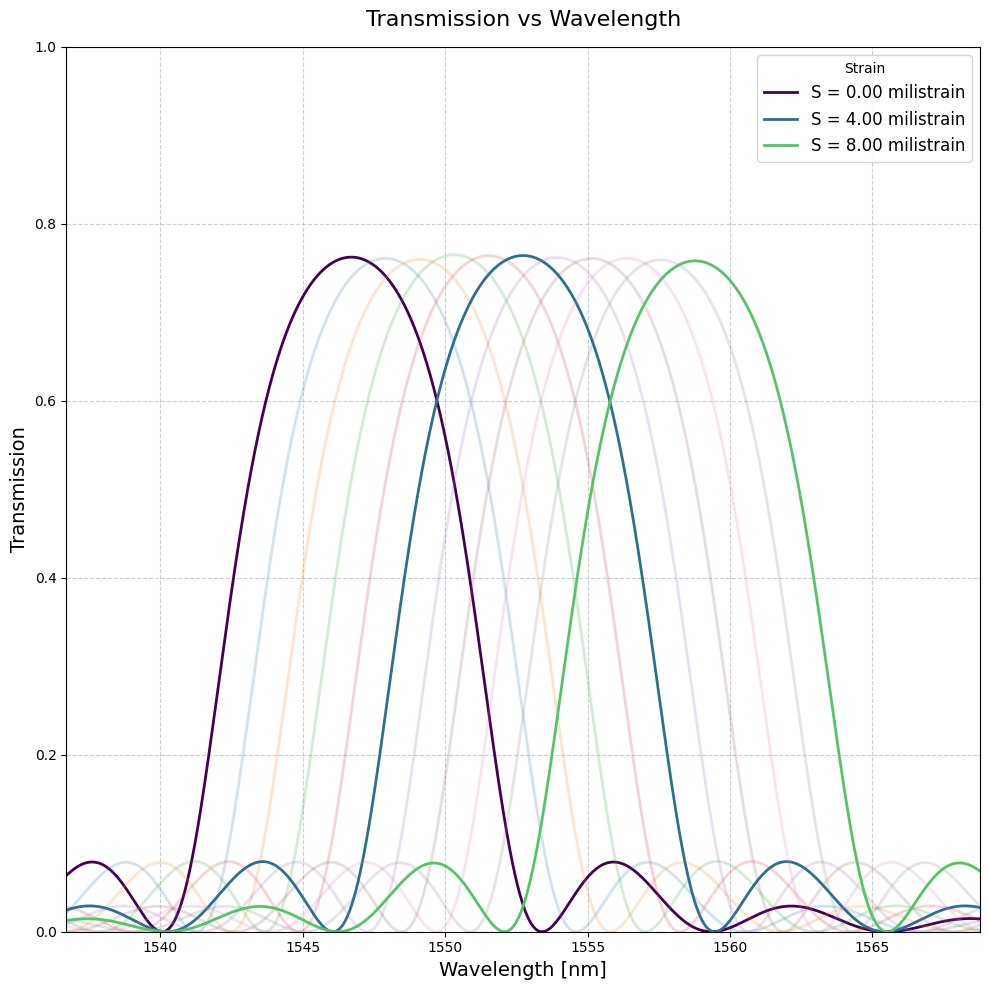

In [449]:
cmap = plt.cm.viridis 

plt.figure(figsize=(10, 10))

for i in range(len(S)):
    if (i%5 == 0):
        plt.plot(
            wvg * 1e9,
            Transmissao[i],
            markerfacecolor='none',  # bola vazada
            markersize=6,
            linewidth=2,
            color=cmap(0.8*i/len(S)),
            label = f"S = {S[i]*1e3:.2f} milistrain"
        )
    else:
        plt.plot(
            wvg * 1e9,
            Transmissao[i],
            markerfacecolor='none',  # bola vazada
            markersize=6,
            alpha = 0.2,
            linewidth=2,
        )

x_max_S1, _ = achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
    Transmissao[0], wvg*1e9, 1500, 1600
)
x_max_S2, _ = achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
    Transmissao[-1], wvg*1e9, 1500, 1600
)

plt.xlim(x_max_S1 - 10, x_max_S2 + 10)
plt.ylim(0, 1)

plt.xlabel("Wavelength [nm]", fontsize=14)
plt.ylabel("Transmission", fontsize=14)
plt.title("Transmission vs Wavelength", fontsize=16, pad=15)

plt.legend(title="Strain", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\transmissao_vs_wavelength_strain.png", dpi=300, bbox_inches="tight")

plt.show()



In [450]:
frequencia_onde_ocorre_maxima_transmissao_strain,_ = analise_comprimento_de_onda_para_sensor(S,Transmissao, wvg*1e9,1500,1600)

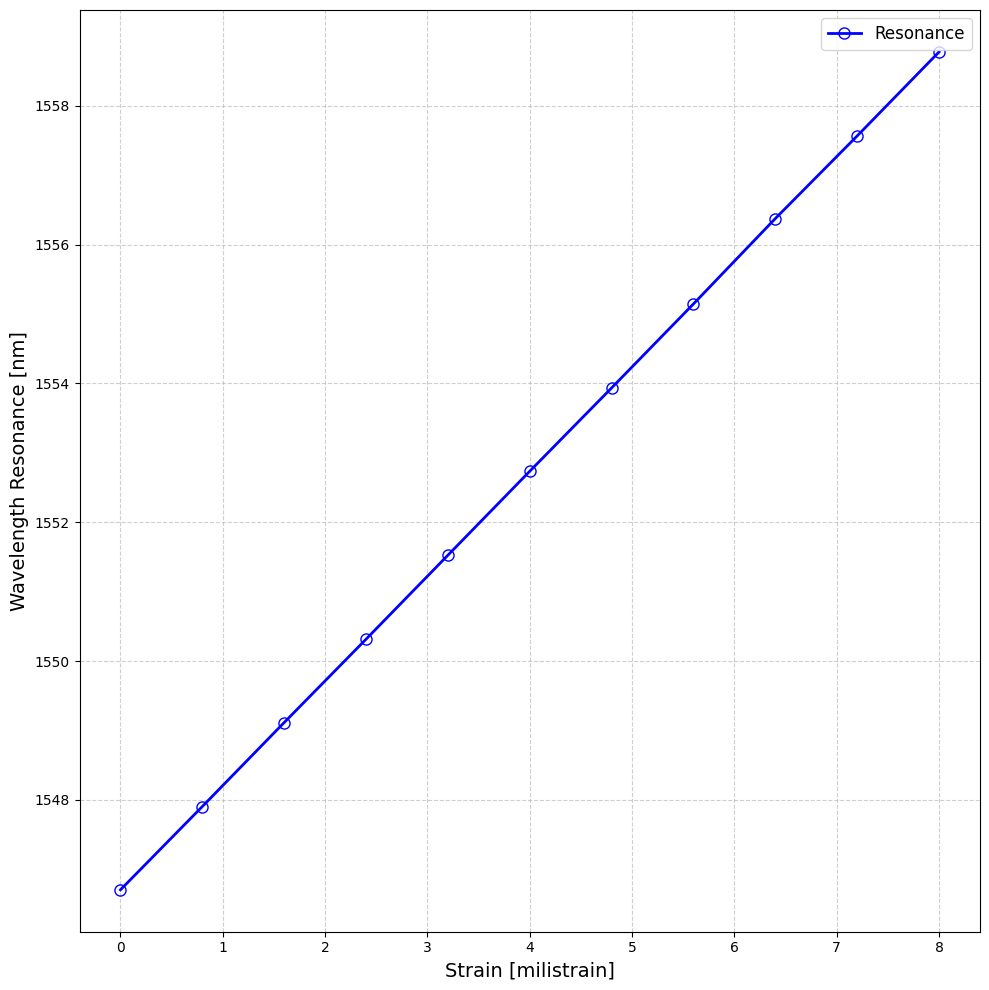

In [451]:
plt.figure(figsize=(10, 10))

plt.plot(
    S*1e3,
    frequencia_onde_ocorre_maxima_transmissao_strain,
    '-o',
    color='blue',
    markerfacecolor='none',  # bola vazada
    markersize=8,
    linewidth=2,
    label="Resonance"
)

plt.xlabel("Strain [milistrain]", fontsize=14)
plt.ylabel("Wavelength Resonance [nm]", fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\ressonancia_vs_strain.png", dpi=300, bbox_inches="tight")

plt.show()


## S parameter Export - Strain 

In [452]:
S11 = np.zeros((len(wvg), 2*len(S)))
S21 = np.zeros((len(wvg), 2*len(S)))

for i in range(0,len(S),1):
    S11[:,2*i] = S11_modulo[i]
    S11[:,2*i+1] = S11_fase[i]

    S21[:,2*i] = S21_modulo[i]
    S21[:,2*i+1] = S21_fase[i]


In [453]:
filepath = r"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG STRAIN"
tamanho = len(os.listdir(filepath))

for i in range(tamanho):
    os.remove(fr"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG STRAIN\bragg_strain_{i+1}.dat")

In [454]:

# Parâmetros
c = 3e8
coln = 3
TM = np.transpose(S)
numMode = 1  # 1 modo
numPort = 2  # 2 portas
modeLabel = ["TE"]  # lista com rótulos de modos

for i in range(len(S)):
    filename = os.getcwd() + fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat"
    with open(filename, "w") as f:
        for kk in range(numMode):
            for mm in range(numPort):  # porta de saída
                for nn in range(numPort):  # porta de entrada
                            mystr = (
                                f"(\"port {mm+1}\",\"{modeLabel[kk]}\",{kk+1},"
                                f"\"port {nn+1}\",1,\"modulation\")\n"
                                f"(1,{1})\n"
                            )
                            f.write(mystr)

                            f.write(f"{S[i]:.5f}" + "\n")

                            f.write(f"({len(wvg)},{coln})\n")

                            # Seleciona o conjunto de dados correto
                            if mm == 0 and nn == 0 and kk == 0:  # S11
                                mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))
                            elif mm == 1 and nn == 0 and kk == 0:  # S21
                                mymtrx = np.column_stack((c / wvg, S21[:,2*i:2*i+2]))
                            else:
                                mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))

                            # Escreve os dados numéricos
                            np.savetxt(f, mymtrx, fmt="%.6e", delimiter="\t")


## Interconnect

In [455]:
interacoes = 1
defasagem = 3.67
qtd_laser = 3

if (interacoes>1):
    defasagem = np.linspace(1,x_max_S2-x_max_S1, interacoes) 


## Strain variation

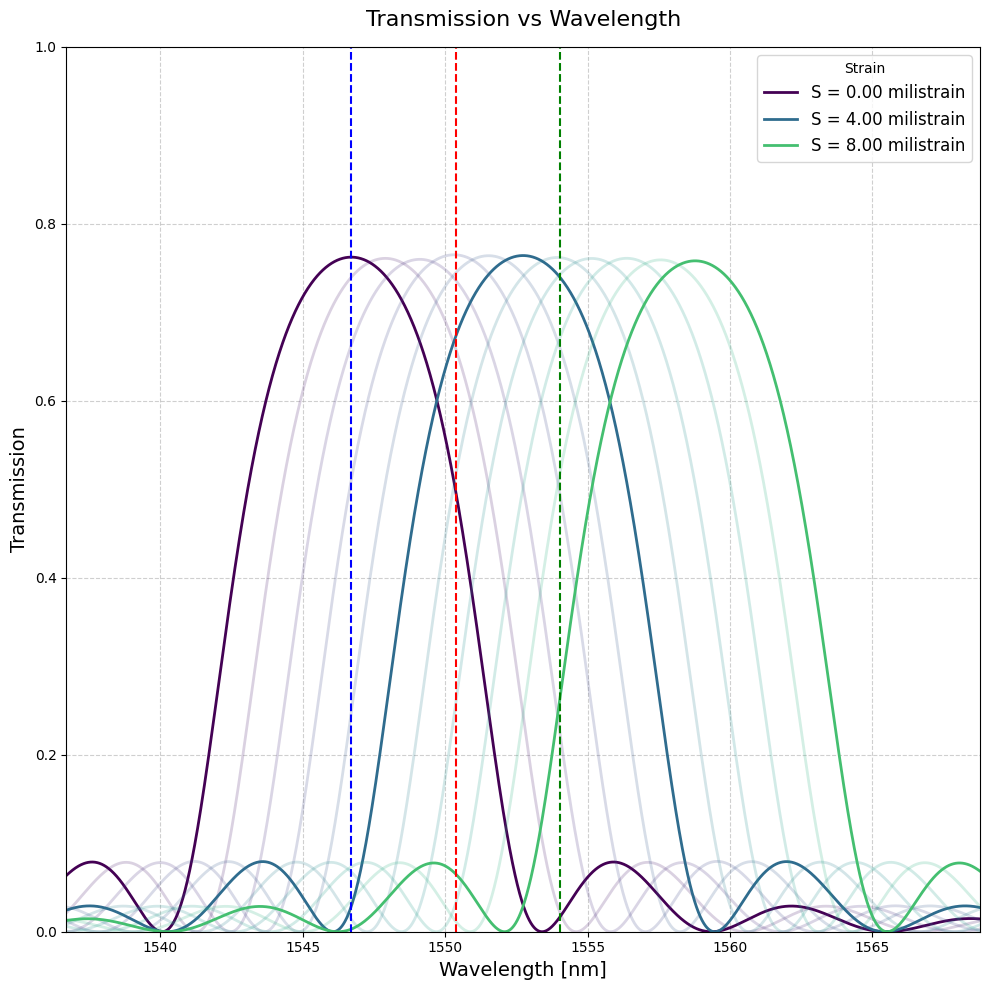

In [459]:

cmap = plt.cm.viridis(np.linspace(0, 0.7, len(S)))

plt.figure(figsize=(10, 10))

for i in range(len(S)):
    if (i%5 == 0):
        plt.plot(
            wvg * 1e9,
            Transmissao[i],
            markerfacecolor='none',  # bola vazada
            markersize=6,
            linewidth=2,
            color=cmap[i],
            label = f"S = {S[i]*1e3:.2f} milistrain"
        )
    else:
        plt.plot(
            wvg * 1e9,
            Transmissao[i],
            markerfacecolor='none',  # bola vazada
            markersize=6,
            alpha = 0.2,
            color= cmap[i],
            linewidth=2,
        )

plt.axvline(x=x_max_S1, color ="blue", linestyle ='--')

if (interacoes >1):
    for j in range(interacoes):
        x_max_S2=frequencia_onde_ocorre_maxima_transmissao_strain[0] + defasagem[j]
        if(j%4 == 0):
            plt.axvline(x=x_max_S2, color ="red",alpha=1, linestyle ='--')
        else:
            plt.axvline(x=x_max_S2, color ="red",alpha=0.2, linestyle ='--')
else:
    plt.axvline(x=x_max_S1+defasagem, color ="red", linestyle ='--')

    if(qtd_laser == 3):
        plt.axvline(x=x_max_S1+2*defasagem, color ="green", linestyle ='--')

plt.xlim(x_max_S1 - 10, x_max_S2 + 10)
plt.ylim(0, 1)

plt.xlabel("Wavelength [nm]", fontsize=14)
plt.ylabel("Transmission", fontsize=14)
plt.title("Transmission vs Wavelength", fontsize=16, pad=15)

plt.legend(title="Strain", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\transmissao_vs_wavelength_strain_com_comprimentos_dos_lasers.png", dpi=300, bbox_inches="tight")

plt.show()



In [464]:
pmS1 = np.zeros([len(S),interacoes])
pmS2 = np.zeros([len(S),interacoes])
pmS3 = np.zeros([len(S),interacoes])
pmS4 = np.zeros([len(S),interacoes])
inter = lumapi.INTERCONNECT()

for j in range(interacoes):
    for i in range(len(S)):
        if(interacoes>1):
            P1,P2 = funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max_S1*1e-9,defasagem[j]*1e-9,os.getcwd() +fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat")
        else:
            P1,P2 = funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max_S1*1e-9,defasagem*1e-9,os.getcwd() +fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat")
            
            if(qtd_laser == 3):
                P3,P4 = funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max_S1*1e-9+defasagem*1e-9,defasagem*1e-9,os.getcwd() +fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat")

        pmS1[i,j] = P1
        pmS2[i,j] = P2
        pmS3[i,j] = P3
        pmS4[i,j] = P4

C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\1476883708.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\1476883708.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(


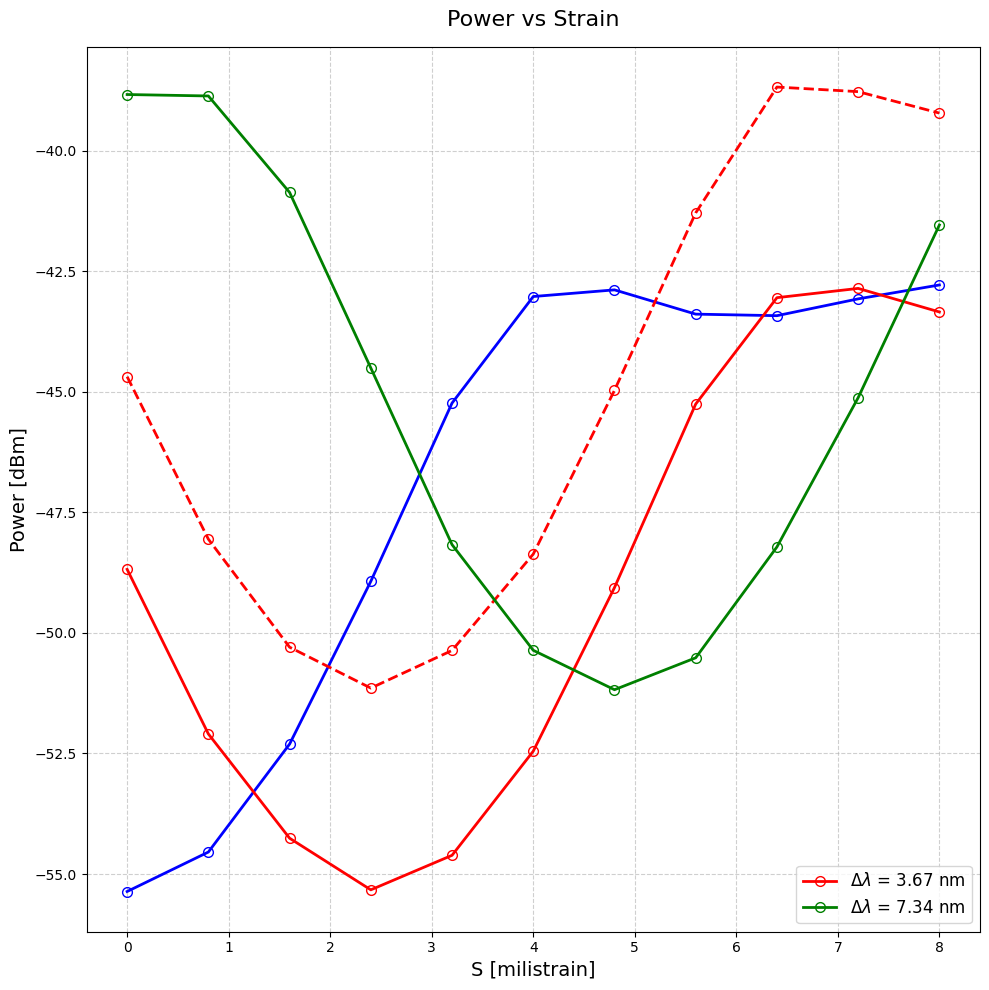

In [467]:
if interacoes == 1:
    plt.figure(figsize=(10, 10))

    for j in range(interacoes):
        plt.plot(
            S*1e3, pmS1[:,j],
            '-o',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            linestyle = "-",
            color = "blue"
        )

        plt.plot(
            S*1e3, pmS2[:,j],
            '-o',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            color = "red",
            label=fr"$\Delta \lambda$ = {defasagem:.2f} nm"
        )
        if(qtd_laser == 3):
            plt.plot(
                S*1e3, pmS3[:,j],
                '-o',
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                linestyle = "--",
                color = "red"
            )

            plt.plot(
                S*1e3, pmS4[:,j],
                '-o',
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                color = "green",
                label=fr"$\Delta \lambda$ = {2*defasagem:.2f} nm"
            )


    plt.xlabel("S [milistrain]", fontsize=14)
    plt.ylabel("Power [dBm]", fontsize=14)
    plt.title("Power vs Strain", fontsize=16, pad=15)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\potencia_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()


<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\D'
<>:90: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\D'
<>:90: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\392336227.py:14: SyntaxWarning: invalid escape sequence '\D'
  label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\392336227.py:24: SyntaxWarning: invalid escape sequence '\D'
  label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\392336227.py:80: SyntaxWarning: invalid escape sequence '\D'
  label=f"$\Delta \lambda$ = {defasagem:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\392336227.py:90: SyntaxWarning: invalid escape seque

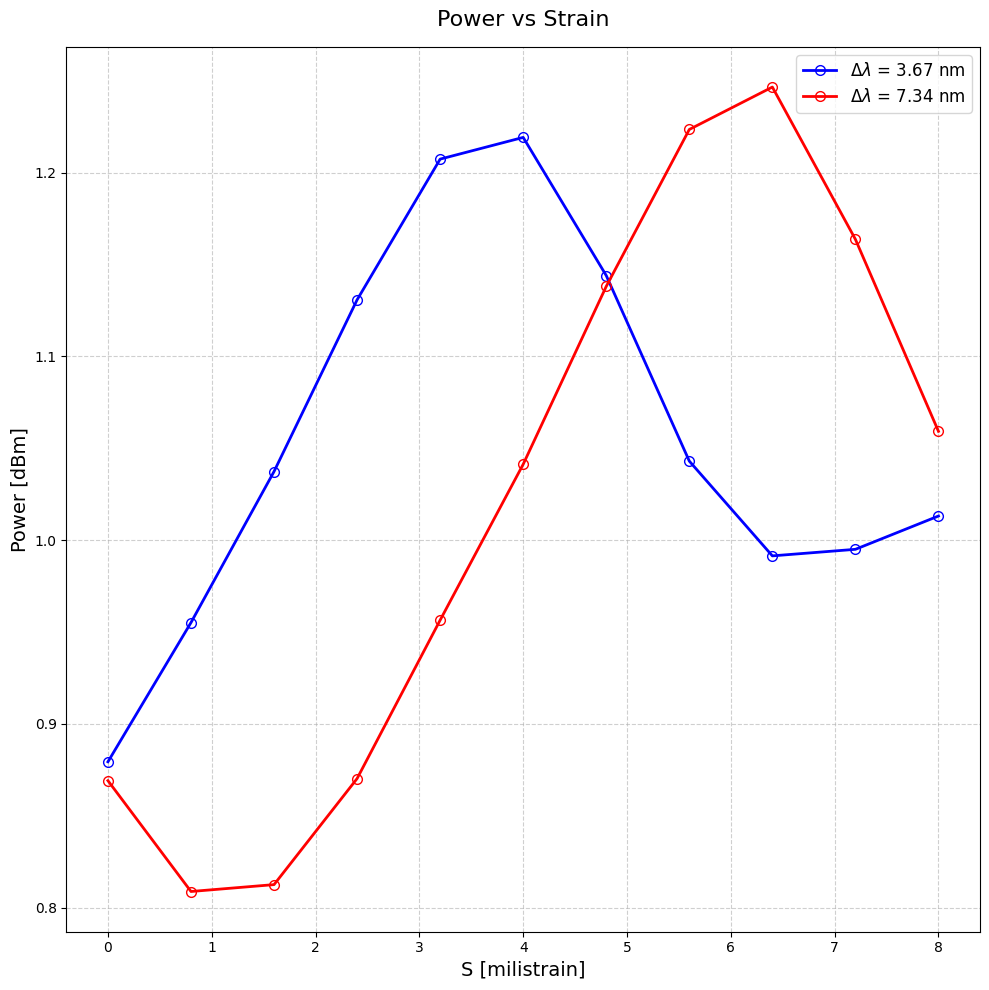

In [470]:
if (interacoes>1):
    plt.figure(figsize=(10, 10))

    for j in range(interacoes):
        
        if j==0:
            plt.plot(
                S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
                '-o',
                color="black",
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
            )
        elif j==7:
            plt.plot(
                S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
                '-o',
                color="red",
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
            )
        # elif j==9:
        #     plt.plot(
        #         S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
        #         '-o',
        #         color="blue",
        #         markerfacecolor='none',
        #         markersize=7,
        #         linewidth=2,
        #         label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
        #     )
        # elif j==29:
        #     plt.plot(
        #         S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
        #         '-o',
        #         color="green",
        #         markerfacecolor='none',
        #         markersize=7,
        #         linewidth=2,
        #         label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
        #     )
        else:
            plt.plot(
                S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
                '-',
                color='red',
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                alpha = 0.2
            )
        
    plt.axvline(x=S[19]*1e3, linestyle="--", label =f"S = {S[19]*1e3:.2f} milistrain")
    plt.xlabel("Strain [milistrain]", fontsize=14)
    plt.ylabel("P1/P2", fontsize=14)
    plt.title("P1/P2 vs Strain", fontsize=16, pad=15)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\razao_potencia_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()
else:
    plt.figure(figsize=(10, 10))

    # Linha 1 com bolas vazadas
    plt.plot(
        S*1e3, pmS2[:,0]/pmS1[:,0],
        '-o',
        color='blue',
        markerfacecolor='none',
        markersize=7,
        linewidth=2,
        label=f"$\Delta \lambda$ = {defasagem:.2f} nm"
    )
    if(qtd_laser==3):
        plt.plot(
            S*1e3, pmS4[:,0]/pmS3[:,0],
            '-o',
            color='red',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            label=f"$\Delta \lambda$ = {2*defasagem:.2f} nm"
        )
    # Labels e título
    plt.xlabel("S [milistrain]", fontsize=14)
    plt.ylabel("Power [dBm]", fontsize=14)
    plt.title("Power vs Strain", fontsize=16, pad=15)

    # Estética
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Salvar em alta resolução
    plt.savefig("potencia_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()


<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\64601487.py:41: SyntaxWarning: invalid escape sequence '\D'
  label = f"$\Delta \lambda$ = {defasagem[j] if (interacoes>1) else defasagem:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_43596\64601487.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


95.21652810160036 por milistrain
97.04975389128475 por milistrain
Erro percentual medio= 0.246 %
Desvio padrao do erro percentual = 0.18127234078833218


<Figure size 1000x1000 with 0 Axes>

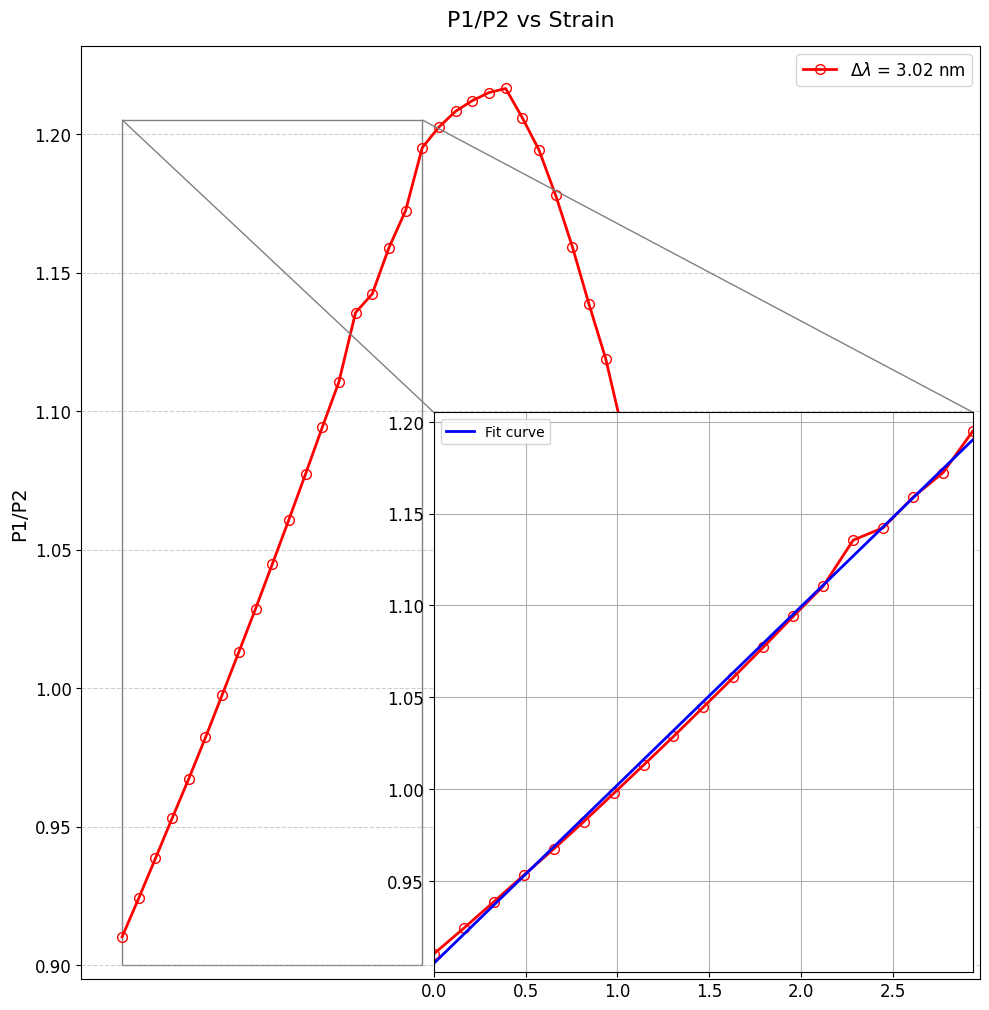

In [ ]:
indice_do_grafico = 0
indice_do_vetor_ate_onde_a_razao_eh_linear = 19


razao=np.array(pmS2[:,indice_do_grafico])/np.array(pmS1[:,indice_do_grafico])
razao_ajustada = razao[0:indice_do_vetor_ate_onde_a_razao_eh_linear]
S_ajustado = S[0:indice_do_vetor_ate_onde_a_razao_eh_linear]

a, b = np.polyfit(S_ajustado*1e-3, razao_ajustada, 1)
y_fit = a*S_ajustado*1e-3 + b

sensibilidade = (razao[indice_do_vetor_ate_onde_a_razao_eh_linear-3]-razao[0])/((S[indice_do_vetor_ate_onde_a_razao_eh_linear-3]-S[0]))
sensibilidade_fit = (y_fit[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-y_fit[0])/((S_ajustado[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-S_ajustado[0]))
erro_percentual = np.abs((razao_ajustada - y_fit) / razao_ajustada) * 100
erro_medio = np.mean(erro_percentual)
desvio_padrao_do_erro_percentual = np.std(erro_percentual)

print(sensibilidade, "por milistrain")
print(sensibilidade_fit, "por milistrain")
print(f"Erro percentual medio= {erro_medio:.3f} %")
print("Desvio padrao do erro percentual =", desvio_padrao_do_erro_percentual)

plt.figure(figsize=(10, 10))

fig, ax = plt.subplots(figsize=(10, 10))

for j in range(interacoes):
    if j==indice_do_grafico:
        ax.plot(
            S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
            '-o',
            color="red",
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            label = f"$\Delta \lambda$ = {defasagem[j] if (interacoes>1) else defasagem:.2f} nm"
        )
    else:
        ax.plot(
            S*1e3, np.array(pmS2[:,j])/np.array(pmS1[:,j]),
            '-',
            color='red',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            alpha = 0.2
        )
ax.set_xlabel("Strain [milistrain]", fontsize=14)
ax.set_ylabel("P1/P2", fontsize=14)
ax.set_title("P1/P2 vs Strain", fontsize=16, pad=15)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_visible(False)  # remove o eixo x e os ticks
ax.tick_params(axis='both', which='major', labelsize=12)  # muda tamanho dos números do eixo x e y

# Criando o inset (zoom)
axins = inset_axes(ax, width="60%", height="60%", loc='lower right')

for j in range(interacoes):
    y = np.array(pmS2[:, j]) / np.array(pmS1[:, j])
    if j == indice_do_grafico:
        axins.plot(
            S*1e3, y,
            '-o',
            color="red",
            markerfacecolor='none',
            markersize=7,
            linewidth=2
        )
    else:
        axins.plot(
            S*1e3, y,
            '-',
            color='red',
            alpha=0.2,
            linewidth=2
        )

axins.plot(
            S_ajustado*1e3, y_fit,
            '-',
            color='blue',
            alpha=1,
            linewidth=2,
            label = "Fit curve"
        )

# Limites do zoom — ajuste conforme região que deseja destacar
x1, x2 = S[0]*1e3, S[indice_do_vetor_ate_onde_a_razao_eh_linear-1]*1e3  # exemplo de limites no eixo x
y1, y2 = min(razao_ajustada)-0.01, max(razao_ajustada)+0.01  # exemplo de limites no eixo y
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.legend()
axins.grid()

# Linha que conecta inset ao gráfico principal
mark_inset(ax, axins, loc1=(1), loc2=2, fc="none", ec="0.5")
axins.tick_params(axis='both', which='major', labelsize=12)  # muda tamanho dos números do eixo x e y

plt.tight_layout()
plt.savefig(os.getcwd() + fr"\RESULTADOS\razao_potencia_e_fit_vs_strain.png", dpi=300, bbox_inches="tight")
plt.show()


## Temperature variation

In [ ]:
pmT1 = []
pmT2 = []

for i in range(len(Temperatura)):
    P1,P2 = funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max1*1e-9,(x_max2-x_max1)*1e-9,os.getcwd() +fr"\BRAGG TEMPERATURE\bragg_temperature_{i+1}.dat")
    pmT1.append(inter.getresult("PM1","total power"))
    pmT2.append(inter.getresult("PM2","total power"))

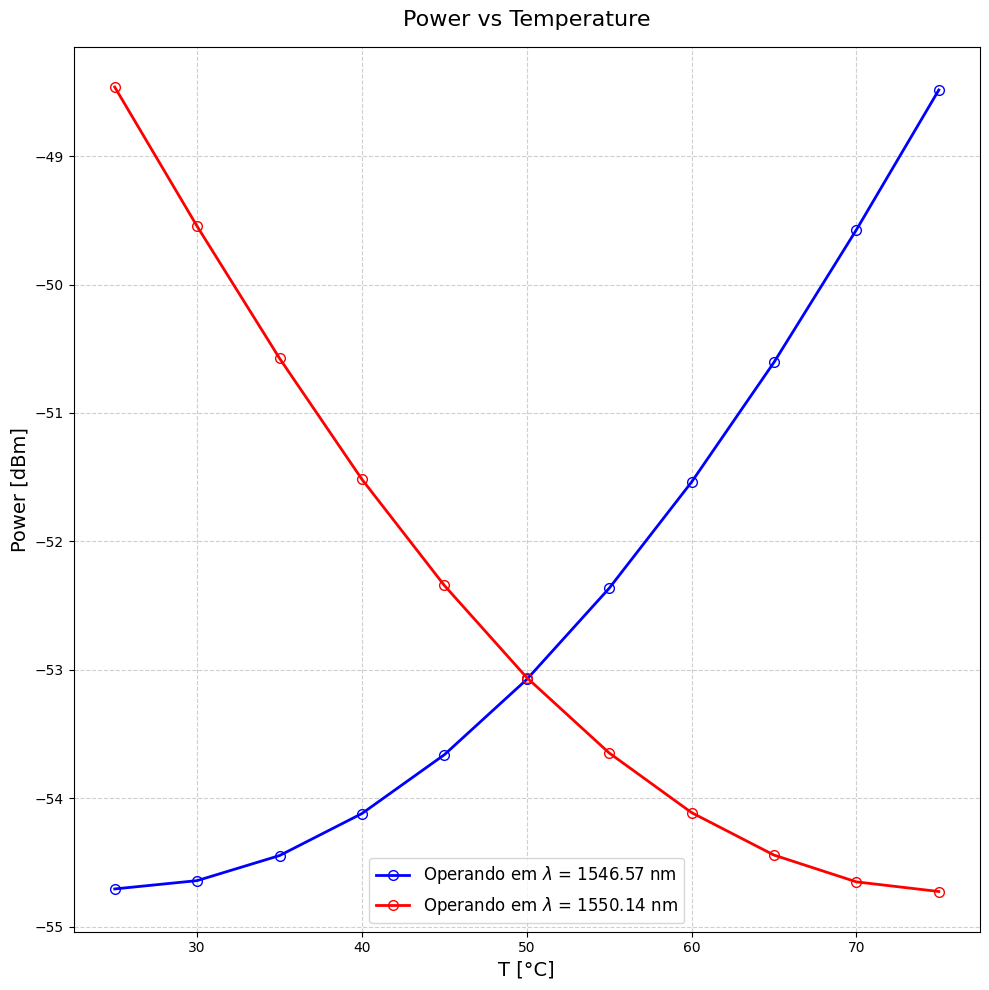

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(
    Temperatura - 273, pmT1,
    '-o',
    color='blue',
    markerfacecolor='none',
    markersize=7,
    linewidth=2,
    label=fr"Operando em $\lambda$ = {x_max1:.2f} nm"
)

plt.plot(
    Temperatura - 273, pmT2,
    '-o',
    color='red',
    markerfacecolor='none',
    markersize=7,
    linewidth=2,
    label=fr"Operando em $\lambda$ = {x_max2:.2f} nm"
)

plt.xlabel("T [°C]", fontsize=14)
plt.ylabel("Power [dBm]", fontsize=14)
plt.title("Power vs Temperature", fontsize=16, pad=15)

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\potencia_vs_temperatura.png", dpi=300, bbox_inches="tight")

plt.show()


## Razão de potências

C:\Users\gson5\AppData\Local\Temp\ipykernel_60468\415684906.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


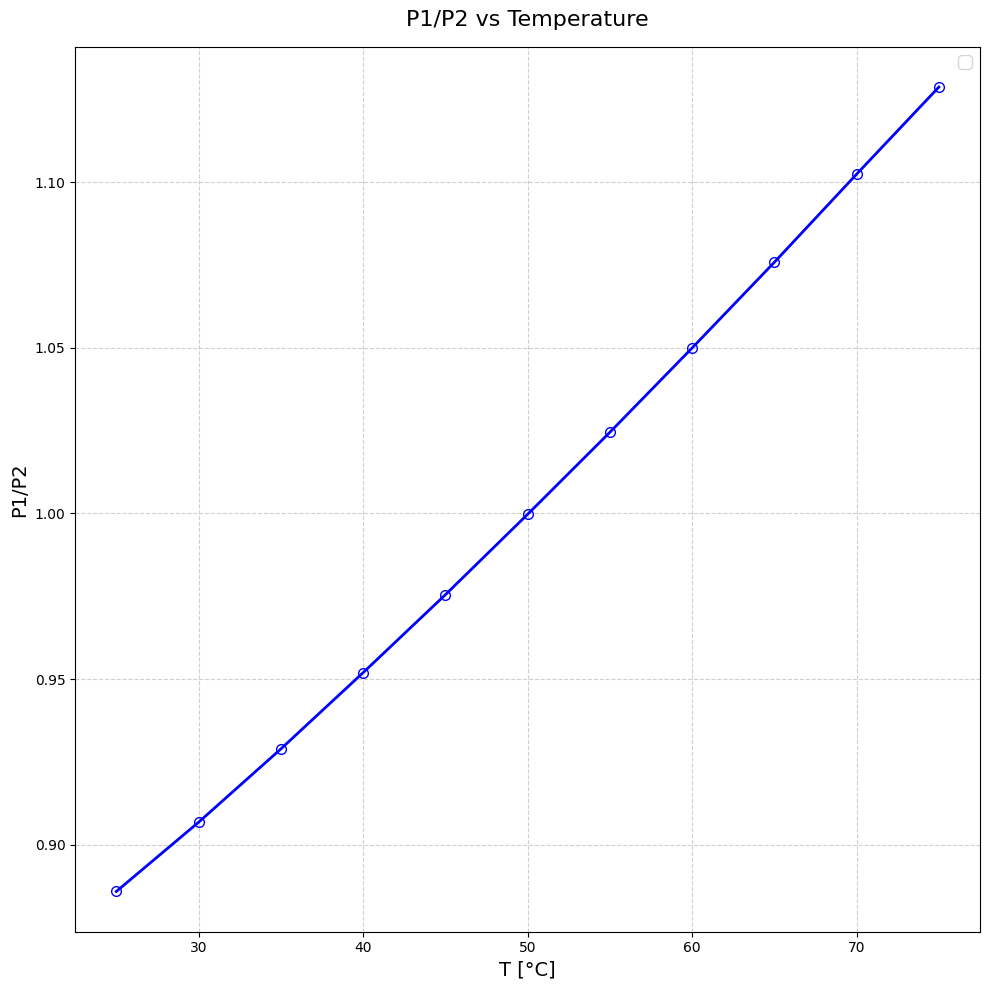

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(
    Temperatura - 273, np.array(pmT2)/np.array(pmT1),
    '-o',
    color='blue',
    markerfacecolor='none',
    markersize=7,
    linewidth=2,
)

plt.xlabel("T [°C]", fontsize=14)
plt.ylabel("P1/P2", fontsize=14)
plt.title("P1/P2 vs Temperature", fontsize=16, pad=15)

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\razao_potencia_vs_temperatura.png", dpi=300, bbox_inches="tight")

plt.show()
